## Install Requirements
******Remember to restart the kernel after installing

In [1]:
%pip install --upgrade pip
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.
Ignoring tensorflow: markers 'sys_platform == "linux"' don't match your environment
Ignoring tensorflow: markers 'sys_platform == "windows"' don't match your environment
Ignoring tensorflow-macos: markers 'sys_platform == "darwin"' don't match your environment
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, sys, shutil
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Setting Up Directories

#### Run preprocessing notebook to process videos into frames

In [3]:
# get generic path to directory
dir_path = os.path.dirname(os.path.realpath("__file__"))

frame_data_dir = os.path.join(dir_path, 'frame_data_movingAvg')
frame_train_data_dir = os.path.join(frame_data_dir, 'train')
frame_test_data_dir = os.path.join(frame_data_dir, 'test')

## Setting Up Generators

In [4]:
from keras.preprocessing.image import ImageDataGenerator

val_split = 0.2
batch_size = 32
target_size = (240, 320)


train_datagen = ImageDataGenerator(
    featurewise_center=True, 
    featurewise_std_normalization=True,
    rescale=1. / 255,
    validation_split=val_split,
)

train_generator = train_datagen.flow_from_directory(
    directory=frame_train_data_dir,
    class_mode="binary",
    subset="training",
    batch_size=batch_size,
    color_mode="grayscale",
    target_size=target_size,
    classes=["Nonleaks", "Leak"]

)

val_generator = train_datagen.flow_from_directory(
    directory=frame_train_data_dir,
    class_mode="binary",
    subset="validation",
    batch_size=batch_size,
    color_mode="grayscale",
    target_size=target_size,
    classes=["Nonleaks", "Leak"]

)


test_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rescale=1. / 255,
)

test_generator = test_datagen.flow_from_directory(
    directory=frame_test_data_dir, 
    class_mode='binary', 
    batch_size=batch_size,
    color_mode="grayscale",
    target_size=target_size,
    classes=["Nonleaks", "Leak"]

)

Found 250316 images belonging to 2 classes.
Found 62577 images belonging to 2 classes.
Found 208668 images belonging to 2 classes.


In [5]:
train_generator.class_indices

{'Nonleaks': 0, 'Leak': 1}

In [6]:
total_batches = train_generator.__len__() + val_generator.__len__()
total_batches

9779

In [7]:
len(train_generator.labels), len(val_generator.labels)

(250316, 62577)

## Class Weigths

In [8]:
total_train_Leak = 0
total_train_NonLeak = 0
gens = [train_generator, val_generator]
for gen in gens:
    for label in gen.labels:
        if label == 0:
            total_train_NonLeak += 1
        elif label == 1:
            total_train_Leak += 1
total_train_Leak, total_train_NonLeak

(277114, 35779)

In [9]:
nonleaks = total_train_NonLeak
leaks = total_train_Leak
total = nonleaks + leaks

weight_nonleak = (1 / nonleaks) * (total / 2.0)
weight_leak = (1 / leaks) * (total / 2.0)

class_weight = {train_generator.class_indices["Nonleaks"]: weight_nonleak, train_generator.class_indices["Leak"]: weight_leak}
class_weight

{0: 4.372578887056654, 1: 0.564556464126677}

## Centering and STD Normalizing Data

#### Helper Functions

In [10]:
def generator_mean(generators):
    feature_sum = 0
    num_elements = 0
    total_batches = 0
    for generator in generators: #had to include this as I am splitting training data with validation data
        batches = 0
        print("Length of Generator", len(generator))
        for data, _ in generator:
            feature_sum += np.sum(data, axis=(0, 1, 2), dtype=np.float64)
            num_elements += np.prod(data.shape[0:3], dtype=np.int64)
            if batches >= len(generator):
                # we need to break the loop by hand because
                # the generator loops indefinitely
                print("Done with one generator!")
                break
            batches += 1
            total_batches += 1
    print("Total Batches", total_batches)
    for generator in generators:
        generator.reset()
        print("Reset Generator")
    return feature_sum/num_elements

def generator_std(generators, mean, centerFirst):
    sum_squared_diff = 0
    num_elements = 0
    total_batches = 0
    og_gens = generators
    lengths_of_gens = [len(gen) for gen in generators]
    if centerFirst:
        generators = [get_with_featurewise_center(gen, mean) for gen in generators]
    for i, generator in enumerate(generators): 
        batches = 0
        print("Length of Generator", lengths_of_gens[i])
        for data, _ in generator:
            squared_diff = (data - mean) ** 2
            sum_squared_diff += np.sum(squared_diff, axis=(0, 1, 2), dtype=np.float64)
            num_elements += np.prod(data.shape[0:3], dtype=np.int64)

            if batches >= lengths_of_gens[i]:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                print("Done with one generator!")
                break
            batches += 1
            total_batches += 1
    print("Total Batches", total_batches)
    for generator in og_gens:
        generator.reset()
        print("Reset Generator")
    return np.sqrt(sum_squared_diff / (num_elements - 1), dtype=np.float64)

def get_with_featurewise_center(generator, mean):
    for data, labels in generator:
        if mean:
            data -= mean
        yield data, labels

def get_with_featurewise_std_norm(generator, std):
    for data, labels in generator:
        if std:
            data /= (std + 1e-6)
        yield data, labels

def get_with_featurewise_center_std_norm (generator, mean, std):
    for data, labels in generator:
        if mean:
            data -= mean
        if std:
            data /= (std + 1e-6)
        yield data, labels

def generate_stats(gens, centerFirst):
    print("Calculating mean...")
    mean = generator_mean(generators=gens)
    print("Done!")
    print("Calculating std from centered data...")
    std = generator_std(generators=gens, mean=mean, centerFirst=centerFirst)
    print("Done!")
    return mean, std

### Generate Stats

In [11]:
# mean, std = generate_stats(gens=[train_generator, val_generator], centerFirst=True)
# mean = mean[0]
# std = std[0]
# mean, std

## Sample Weights

In [12]:
#TODO: calculate sample_weights using train_generator | should be similar to how predictions are made at the bottom of the notebook
#I think this should work but not sure

# A DirectoryIterator yielding tuples of (x, y) where x is a numpy array 
# containing a batch of images with shape (batch_size, *target_size, channels) 
# and y is a numpy array of corresponding labels. (In our case its train_generator)

# def sample_weights(data):
#     weights = []
#     zero_sum = 0
#     for data, _ in train_generator:
#        batch_size = data.shape[0]
#        for image_index in range(batch_size):
#             image = data[image_index]
#             summed_pixels = np.sum(image)
#             if summed_pixels == 0:
#                 weights.append(0)
#                 zero_sum += 1
#             else:
#                 # try using sqrt transformation for weight skew
#                 # weights.append(1 / np.sqrt(summed_pixels))
#                 weights.append(1 / summed_pixels)
#     train_generator.reset()
#     median_weight = np.median(weights)
#     weights = [median_weight if weight == 0 else weight for weight in weights]
#     return weights

## Model

In [13]:
# from keras import layers 
# from keras import models 

# model = models.Sequential() 

# # Conv Pool 1
# model.add(layers.Conv2D(4, (3, 3), input_shape=(240, 320, 1)))
# model.add(layers.BatchNormalization())
# model.add(layers.ReLU())
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.5))


# model.add(layers.Flatten())

# model.add(layers.Dense(32, activation='relu')) 
# model.add(layers.Dense(1, activation='sigmoid')) 

# model.summary()

In [14]:
from keras import layers 
from keras import models 

model = models.Sequential() 

# Conv Pool 1
model.add(layers.Conv2D(4, (3, 3), input_shape=(240, 320, 1)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

# Conv Pool 2
model.add(layers.Conv2D(8, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))


model.add(layers.Flatten())

model.add(layers.Dense(2400, activation='relu', kernel_regularizer='l2')) # adds a penalty to the model's loss function based on the size of the weights, discouraging overly complex models
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu', kernel_regularizer='l2')) #result right now are without it
model.add(layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 318, 4)       40        
                                                                 
 batch_normalization (BatchN  (None, 238, 318, 4)      16        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 238, 318, 4)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 119, 159, 4)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 119, 159, 4)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 157, 8)       2

In [15]:
# from keras import layers 
# from keras import models 

# model = models.Sequential() 

# # Conv Pool 1
# model.add(layers.Conv2D(4, (3, 3), input_shape=(240, 320, 1)))
# model.add(layers.BatchNormalization())
# model.add(layers.ReLU())
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.5))

# # Conv Pool 2
# model.add(layers.Conv2D(8, (3, 3)))
# model.add(layers.BatchNormalization())
# model.add(layers.ReLU())
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.5))

# # Conv Pool 3
# model.add(layers.Conv2D(8, (3, 3)))
# model.add(layers.BatchNormalization())
# model.add(layers.ReLU())
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.5))

# # Conv Pool4
# model.add(layers.Conv2D(4, (3, 3)))
# model.add(layers.BatchNormalization())
# model.add(layers.ReLU())
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.5))

# model.add(layers.Flatten())

# model.add(layers.Dense(2400, activation='relu')) 
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(32, activation='relu')) 
# model.add(layers.Dense(1, activation='sigmoid')) 

# model.summary()

## Training Model

In [16]:
from keras import optimizers 
import keras.backend as K

def f1_score(y_true, y_pred):
    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    recall = true_positives / (all_positives + K.epsilon())

    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=1e-4), 
              metrics=[f1_score, "acc"], 
              run_eagerly=True
              )


## Data Visualization (Confusion Matrix and ROC Curves)

In [17]:
#code from https://neptune.ai/blog/keras-metrics
#to use to plot confusion matrix and roc curve after each epock
#uncomment when you need it 

import os

from keras.callbacks import Callback
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

class PerformanceVisualizationCallback(Callback):
    def __init__(self, model, validation_data, num_batches, image_dir):
        super().__init__()
        self.model = model
        self.validation_data = validation_data
        self.num_batches = num_batches

        os.makedirs(image_dir, exist_ok=True)
        self.image_dir = image_dir

    def on_epoch_end(self, epoch, logs={}):
        y_true = []
        y_pred = []
        y_pred_processed = []
        batch_num = 0
        for data, true_label in self.validation_data:
            batch_pred = self.model.predict(data, verbose=0)
            
            processed_preds = (batch_pred >= 0.5).flatten().astype(int)
            y_pred_processed.extend(processed_preds)
            y_pred.extend(batch_pred)
            y_true.extend(true_label.astype(int))

            if batch_num >= self.num_batches:
                break
            batch_num += 1
        print(len(y_true), len(y_pred), len(y_pred_processed))
        # plot and save confusion matrix
        fig, ax = plt.subplots(figsize=(16,12))
        cm = confusion_matrix(y_true, processed_preds)
        cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax, name=f"Confusion Matrix of Validation Data at Epoch {epoch} (Threshold = 0.5)")
        fig.savefig(os.path.join(self.image_dir, f'confusion_matrix_epoch_{epoch}'))

       # plot and save roc curve
        fig, ax = plt.subplots(figsize=(16,12))
        
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax, name=f"ROC Curve of Validation Data at Epoch {epoch}")
        fig.savefig(os.path.join(self.image_dir, f'roc_curve_epoch_{epoch}'))

performance_cbk = PerformanceVisualizationCallback(
                      model=model,
                      validation_data=val_generator, #get_with_featurewise_center_std_norm(val_generator, mean, std),
                      num_batches=len(val_generator),
                      image_dir='performance_vizualizations')

In [18]:

num_epochs = 5

earlyStop = tf.keras.callbacks.EarlyStopping(min_delta=0.01,monitor='f1_score', patience=2)

history = model.fit_generator(
    generator = train_generator, #get_with_featurewise_center_std_norm(train_generator, mean, std),
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator, #get_with_featurewise_center_std_norm(val_generator, mean, std),
    validation_steps = val_generator.samples // batch_size,
    epochs = num_epochs,
    class_weight = class_weight,
    callbacks=[earlyStop] #uncomment once you want to use it
)

Epoch 1/5


C:\Users\bestlab\AppData\Local\Temp\ipykernel_3400\2196971274.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
c:\Users\bestlab\Squishy-Methane-Analysis\lib\site-packages\keras\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
c:\Users\bestlab\Squishy-Methane-Analysis\lib\site-packages\keras\preprocessing\image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


7822/7822 [==============================] - 6223s 796ms/step - loss: 1.8619 - f1_score: 0.8533 - acc: 0.8691 - val_loss: 1.1716 - val_f1_score: 0.7034 - val_acc: 0.6371
Epoch 2/5
7822/7822 [==============================] - 6236s 797ms/step - loss: 0.2559 - f1_score: 0.9277 - acc: 0.9780 - val_loss: 0.8056 - val_f1_score: 0.8124 - val_acc: 0.7482
Epoch 3/5
7822/7822 [==============================] - 6257s 800ms/step - loss: 0.2147 - f1_score: 0.9309 - acc: 0.9841 - val_loss: 0.7148 - val_f1_score: 0.8468 - val_acc: 0.7632


## Model Metrics Over Epochs

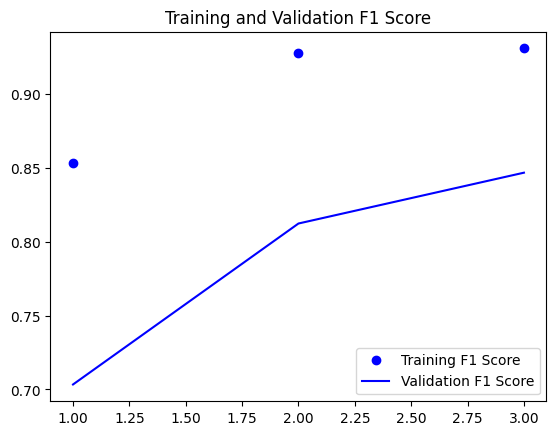

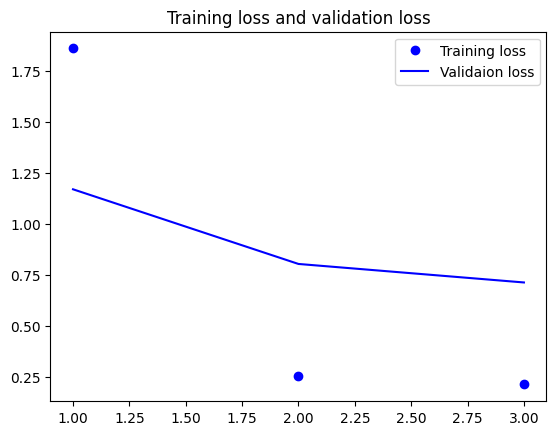

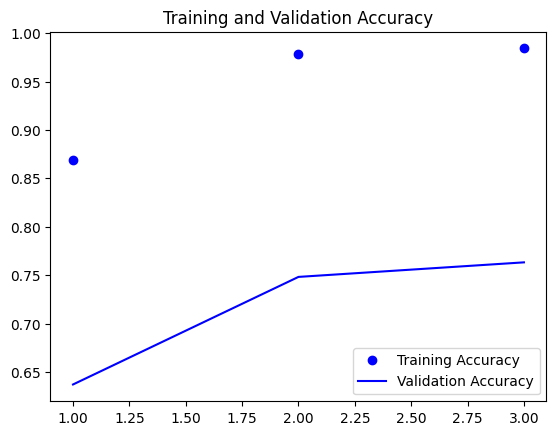

<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt 

f1 = history.history['f1_score'] 
val_f1 = history.history['val_f1_score'] 

loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

acc = history.history["acc"]
val_acc = history.history["val_acc"]

epochs = range(1, len(f1) + 1) 

plt.plot(epochs, f1, 'bo', label='Training F1 Score') 
plt.plot(epochs, val_f1, 'b', label='Validation F1 Score') 
plt.title('Training and Validation F1 Score') 
plt.legend() 

plt.figure() 

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validaion loss') 
plt.title('Training loss and validation loss') 
plt.legend() 

plt.figure() 

plt.plot(epochs, acc, 'bo', label='Training Accuracy') 
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy') 
plt.title('Training and Validation Accuracy') 
plt.legend() 

plt.figure() 

plt.show() 

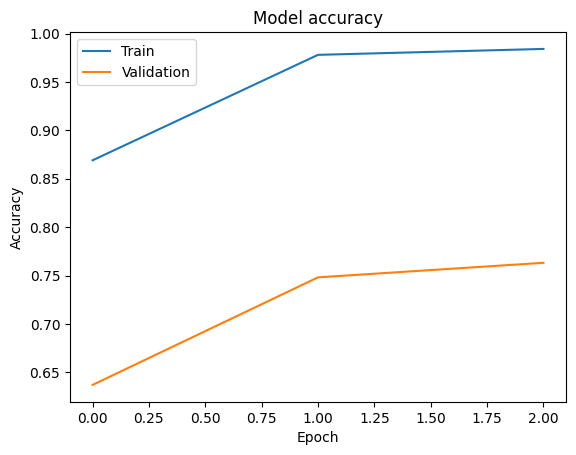

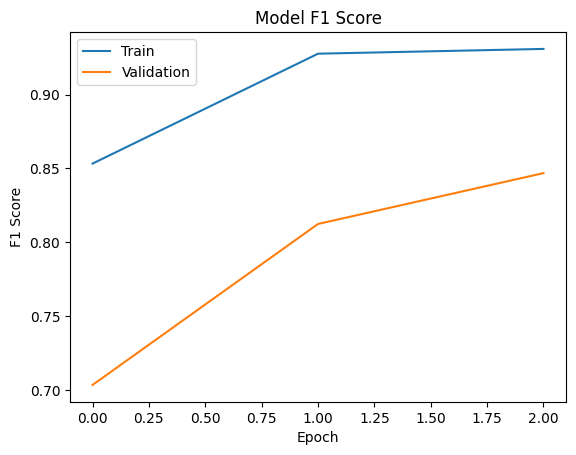

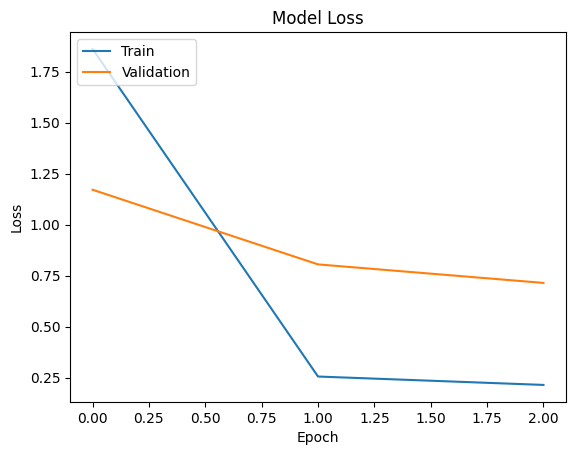

<Figure size 640x480 with 0 Axes>

In [20]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.figure()

plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.figure()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.figure()


plt.show()

## Testing

### Generate Stats

In [21]:
# test_mean, test_std = generate_stats(gens=[test_generator], centerFirst=True)
# test_mean = test_mean[0]
# test_std = test_std[0]

### Getting Predictions from Test Data

In [22]:
#source: https://stackoverflow.com/questions/45413712/keras-get-true-labels-y-test-from-imagedatagenerator-or-predict-generator

# Create lists for storing the predictions and labels
predictions = []
true_labels = []

threshold = 0.5
# Get the total number of labels in generator 
# (i.e. the length of the dataset where the generator generates batches from)
length_test = len(test_generator.labels)

# Loop over the generator
for data, label in test_generator: #get_with_featurewise_center_std_norm(test_generator, test_mean, test_std):
    # Make predictions on data using the model. Store the results.
    preds = model.predict(data, verbose=0)
    processed_preds = (preds >= threshold).flatten().astype(int)
    predictions.extend(processed_preds)
    # Store corresponding labels
    true_labels.extend(label.astype(int))
    
    # We have to break out from the generator when we've processed 
    # the entire once (otherwise we would end up with duplicates). 
    if len(predictions) == length_test:
        break

In [23]:
len(predictions), len(true_labels)

(208668, 208668)

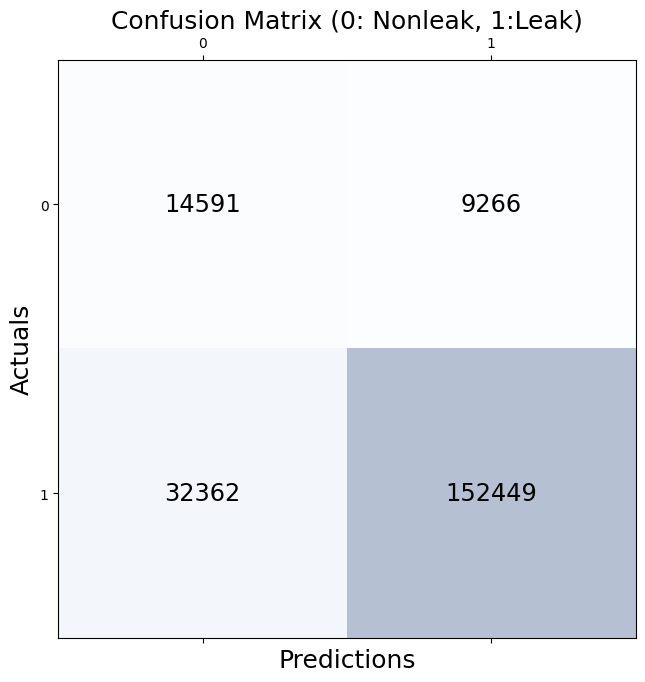

In [24]:
from sklearn.metrics import confusion_matrix

#source: https://vitalflux.com/python-draw-confusion-matrix-matplotlib/

conf_matrix = confusion_matrix(y_true=true_labels, y_pred=predictions)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix (0: Nonleak, 1:Leak)', fontsize=18)
plt.show()

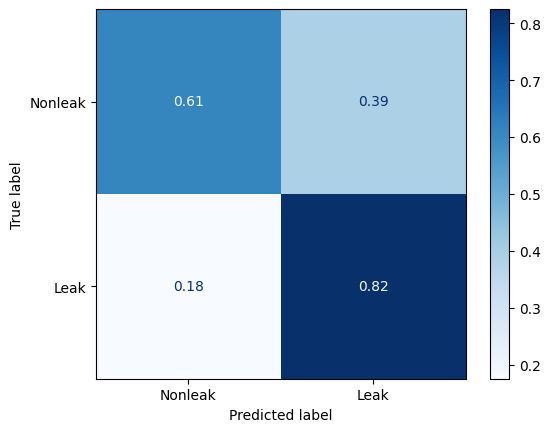

In [26]:
cm_display = ConfusionMatrixDisplay(conf_matrix).from_predictions(y_true=true_labels, y_pred=predictions, normalize='true', cmap=plt.cm.Blues, display_labels=['Nonleak', 'Leak'])
plt.show()

In [27]:
# Extract the true positive, true negative, false positive, and false negative values from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()
 
# Print the true positive, true negative, false positive, and false negative values
print("True Positive (TP): ", tp)
print("True Negative (TN): ", tn)
print("False Positive (FP): ", fp)
print("False Negative (FN): ", fn)
 
# Calculate accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)
 
# Calculate precision
precision = tp / (tp + fp)
 
# Calculate recall
recall = tp / (tp + fn)
 
# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)
 
# Print the formulas for accuracy, precision, recall, and F1-score
print("\n\nFormulas:")
print("Accuracy: (TP + TN) / (TP + TN + FP + FN)")
print("Precision: TP / (TP + FP)")
print("Recall: TP / (TP + FN)")
print("F1-score: 2 * (Precision * Recall) / (Precision + Recall)")
 
# Print the accuracy, precision, recall, and F1-score
print("\n\nMetrics:")
print("Accuracy: ", round(accuracy, 4))
print("Precision: ", round(precision, 4))
print("Recall: ", round(recall, 4))
print("F1-score: ", round(f1_score, 4))

True Positive (TP):  152449
True Negative (TN):  14591
False Positive (FP):  9266
False Negative (FN):  32362


Formulas:
Accuracy: (TP + TN) / (TP + TN + FP + FN)
Precision: TP / (TP + FP)
Recall: TP / (TP + FN)
F1-score: 2 * (Precision * Recall) / (Precision + Recall)


Metrics:
Accuracy:  0.8005
Precision:  0.9427
Recall:  0.8249
F1-score:  0.8799


## Other Stuff

In [ ]:


# def get_test_FN_frames(generator, total):
#     res = []
#     fn_indices = [i for i in range(len(predictions)) if predictions[i] == 0 and true_labels[i] == 1]
#     fn_indices = np.random.choice(fn_indices, total, replace=False)
#     fn_set = set(fn_indices)
#     batch_num = 0
#     for i in range(total):
#         i_fn = fn_indices[i]
#         i_batch = i_fn // batch_size
#         data, _ = generator.__getitem__(i_batch)
#         res.append(data[i_fn % batch_size])
#     return res
# frames_FN = get_test_FN_frames(test_generator, 10)
#frames_FN

In [ ]:
# def plot_images(images):
#     for i, img in enumerate(images):
#         cv2.imshow(f"Image {i + 1}", img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
# plot_images(frames_FN)